# Kaggle Quito Dataset Analysis

This data set is from the Kaggle competition you can find [here](https://www.kaggle.com/mnavas/taxi-routes-for-mexico-city-and-quito). 

The data set contains features collected from taxi drives in the city Quito. The taxi passengers used an app that collected the coordinates of the start and stop location, the time and date, the duration of the trip, the distance and the time the car was stopped. The time where the car was stopped relates to the time the passanger had to wait in traffic. Therefore this is a desired feature to predict for future rides. The question we will be analysing here is: 

**How long will I be stuck in traffic?**

In [1]:
# import libraries

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime, date
%matplotlib inline
#plt.style.use( 'dark_background')

In [2]:
#import dataset
df = pd.read_csv("uio_clean.csv")
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,dist_meters,wait_sec
0,1,Quito,2016-09-17 09:32:06,2016-09-17 10:05:51,-78.503922,-0.232824,-78.549447,-0.361363,N,2025,24228,346
1,2,Quito,2016-09-18 04:03:20,2016-09-18 04:26:30,-78.440306,0.006789,-78.490786,-0.104836,N,1390,16680,456
2,3,Quito,2016-09-16 06:29:36,2016-09-18 06:41:33,-78.469551,-0.143636,-78.470277,-0.131083,N,130317,1987,290
3,4,Quito,2016-09-18 05:57:47,2016-09-18 06:30:00,-78.558076,-0.278241,-78.430220,-0.201934,N,1933,25146,302
4,5,Quito,2016-09-18 07:58:42,2016-09-18 08:14:29,-78.521818,-0.208480,-78.504558,-0.222462,N,948,4625,314


## Data Exploration

In [3]:
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration',
       'dist_meters', 'wait_sec'],
      dtype='object')

In [4]:
# checking for missing values
df.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dist_meters           0
wait_sec              0
dtype: int64

In [5]:
# checking the data types
print(df.dtypes)

id                      int64
vendor_id              object
pickup_datetime        object
dropoff_datetime       object
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dist_meters             int64
wait_sec                int64
dtype: object


### Exploring each feature

#### Vendor_ID

In [6]:
# vendor_id column: 

print('Data type of vendor_id: ', df.vendor_id.dtype)
print('Nr of different vendors:', df.vendor_id.unique().size)

#which vendor occures most?
vendors = df.vendor_id
vendor_counts = vendors.value_counts()
print('Occurences of vendor_ids:', vendor_counts)
print('max', vendor_counts[vendor_counts == vendor_counts.max()])

Data type of vendor_id:  object
Nr of different vendors: 4
Occurences of vendor_ids: Quito                     31875
Quito Cabify Lite           400
Quito Cabify Executive       88
Quito UberX                   3
Name: vendor_id, dtype: int64
max Quito    31875
Name: vendor_id, dtype: int64


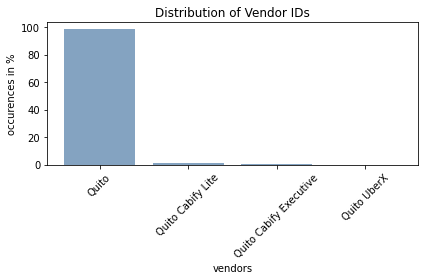

In [7]:
# make barplot with vendor_ids
vendor_array = np.array(vendor_counts)/sum(vendor_counts) *100
names = vendors.unique()
x_axis = np.arange(1,vendor_array.size +1)

plt.bar(x = names, height = vendor_array, color=(0.2, 0.4, 0.6, 0.6))
plt.xlabel('vendors')
plt.ylabel('occurences in %')
plt.title('Distribution of Vendor IDs')
plt.xticks(rotation=45)
plt.gcf().patch.set_alpha(0.0)
plt.gca().patch.set_alpha(0.0)
plt.tight_layout()

**Note:** Since the feature *vendor_id* mostly contains the vendor Quito, the other vendors can be removed, or this could be handled with one-hot encoding. I will decide to remove the vendors unequal to 'Quito'.

#### Time Points

In [8]:
# transforming to datetime
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])
print('data type of pickup_datetime: ', df.pickup_datetime.dtype)

data type of pickup_datetime:  datetime64[ns]


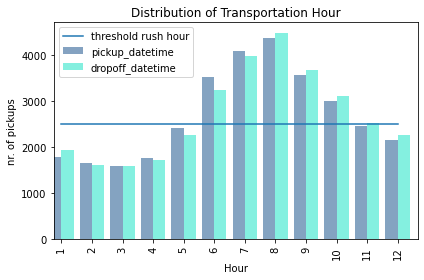

In [9]:
# When are the pickups and dropoffs?
# plotting the occurences of pickup hours

pickups_per_hour = df['pickup_datetime'].dt.hour.value_counts().sort_index()
dropoffs_per_hour = df['dropoff_datetime'].dt.hour.value_counts().sort_index()

plt.figure()
pickups_per_hour.plot.bar(color=(0.2, 0.4, 0.6, 0.6), position=1, width= 0.4)
dropoffs_per_hour.plot.bar(color=(0.2, 0.9, 0.8, 0.6), position=0, width= 0.4)
plt.plot(np.array([i for i in range(12)]),[2500 for i in range(12)], label='threshold rush hour')
plt.xlabel('Hour')
plt.ylabel('nr. of pickups')
plt.title('Distribution of Transportation Hour')
plt.gcf().patch.set_alpha(0.0)
plt.gca().patch.set_alpha(0.0)
plt.tight_layout()
plt.legend(loc=2) 
plt.show()

**Note:** There seems to be a rush hour at 6 - 9. Something I noticed in the data is the lack of annotation of AM and PM, which might have an influence on the actual rush hour times. However, it is reasonable to assume, that the nighttime hours are equally less busy and don't have a hughe effect on the total number of pickups per hour. 

In [10]:
# transportation per day

pickups_per_day = df['pickup_datetime'].dt.date.value_counts().sort_index()

# time range of data set
print('first day: ', pickups_per_day.index[0])
print('last day: ', pickups_per_day.index[-1])

print('mean of pickups per day: ', pickups_per_day.mean())

first day:  2014-12-31
last day:  2017-08-01
mean of pickups per day:  77.61630695443645


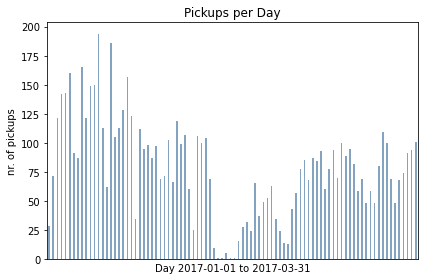

In [11]:
# plotting transportation per day during 2016
start = date(2017, 1, 1)
end = date(2017, 3, 31)
three_month_mask = (pickups_per_day.index >= start) & (pickups_per_day.index <= end)
three_month = pickups_per_day[three_month_mask]

plt.figure()
three_month.plot.bar(color=(0.2, 0.4, 0.6, 0.6), position=1, width= 0.4)
plt.xlabel('Day 2017-01-01 to 2017-03-31')
plt.ylabel('nr. of pickups')
plt.title('Pickups per Day')
plt.tick_params( bottom=False, labelbottom=False)
plt.gcf().patch.set_alpha(0.0)
plt.gca().patch.set_alpha(0.0)
plt.tight_layout()
plt.show()

**Note:** There seem to be days without recordings of the app. These could be removed in the cleaning step later.

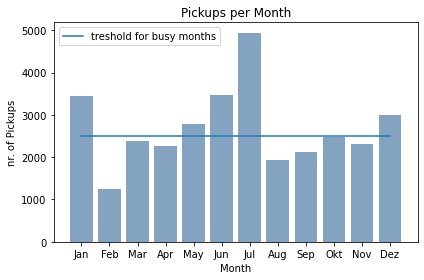

In [12]:
# plotting pickups per month

month_name = np.array(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Okt', 'Nov', 'Dez'])

month = df['pickup_datetime'].dt.month.value_counts().sort_index()
plt.figure()
plt.bar(x=month_name, height=month.values, color=(0.2, 0.4, 0.6, 0.6))
plt.plot(month_name,[2500 for i in range(len(month_name))], label='treshold for busy months')
plt.title('Pickups per Month')
plt.legend()
plt.xlabel('Month')
plt.ylabel('nr. of Pickups')
plt.gca().patch.set_alpha(0.0)
plt.gcf().patch.set_alpha(0.0)
plt.tight_layout()
plt.show()

**Note:** Dezember, January, June and July seem to be month with higher ammount of pickups. This could be translatet in a featuer month or season.

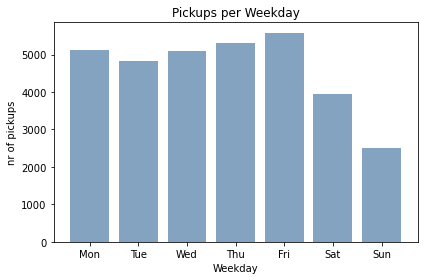

In [13]:
# plotting the average number of pickups per weekday

weekdays = df['pickup_datetime'].dt.dayofweek.value_counts().sort_index()
weekday_name = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

plt.figure()
plt.bar(x=weekday_name, height=weekdays, color=(0.2, 0.4, 0.6, 0.6))
plt.title('Pickups per Weekday')
plt.xlabel('Weekday')
plt.ylabel('nr of pickups')
plt.gcf().patch.set_alpha(0.0)
plt.gca().patch.set_alpha(0.0)
plt.tight_layout()
plt.show()

**Note:** The weekday also seems to be an important feature, the weekend is less busy than the weekdays.

#### Coordinates:

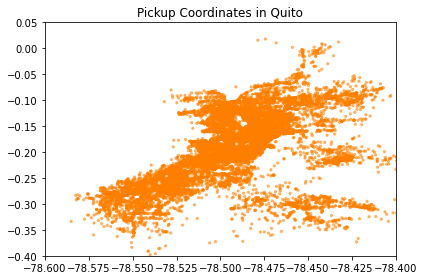

In [14]:
# plotting the pickup coordinates, only using the area of Quito 
# looked up the coordinate range of Quito at https://www.latlong.net/

median = df.wait_sec.median()
mad = df.wait_sec.mad()


plt.figure()

#sns.scatterplot(data=df, x='pickup_longitude', y='pickup_latitude', alpha=0.5, s=6, ax=ax);
plt.scatter(df.pickup_longitude, df.pickup_latitude, 
            s=5, alpha=0.5, cmap='afmhot', c=df.wait_sec)
plt.xlim([-78.6,-78.4])
plt.ylim([-0.4,0.05])
plt.title('Pickup Coordinates in Quito')

plt.clim(median - 3 * mad, median + 3 * mad)
plt.gcf().patch.set_alpha(0.0)
plt.gca().patch.set_alpha(0.0)
plt.tight_layout()
plt.show()

**Note:** Most of the trips seem to start in the city center and also the waiting time has areas in the city center that seem to be higher. This can be translatet in features like the direction of the trip: out of the city or into the city.

#### Trip duration and distance:

In [15]:
# trip_duration seconds
print('minimum trip_duration: ', df.trip_duration.min())
# How many values are negative?
print('how many values are < 0 ?:', df.trip_duration.loc[df.trip_duration < 0].size)
print('maximum: ', df.trip_duration.max())
# The maximum seems very high, translating to days:
print('maximum value in days: ', df.trip_duration.max()/60/60/24)
print('how many values are longer than 8 hours: ',df.trip_duration.loc[df.trip_duration > (8*60*60)].size )
# How many trips are shorter than 5 minutes? 
print('trips shorter than 5 minutes: ', df.trip_duration.loc[df.trip_duration < 5*60].size)

minimum trip_duration:  -388711
how many values are < 0 ?: 1
maximum:  70026052
maximum value in days:  810.486712962963
how many values are longer than 8 hours:  2070
trips shorter than 5 minutes:  4012


**Note:** Here negative values and values longer than 8 hours are concidered as unrealistic and should be removed later. Also trips under 5 minutes could be concidered as wrong data points since trips that short are unrealistic for a taxi drive.

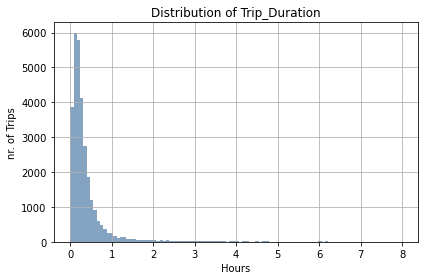

In [16]:
duration = df.trip_duration.loc[df.trip_duration > 0]
duration = duration.loc[duration < 8*60*60]/60/60

plt.figure()
duration.hist(bins=100, color=(0.2, 0.4, 0.6, 0.6))
plt.title('Distribution of Trip_Duration')
plt.xlabel('Hours')
plt.ylabel('nr. of Trips')
plt.gcf().patch.set_alpha(0.0)
plt.gca().patch.set_alpha(0.0)
plt.tight_layout()
plt.show()

**Note:** Most trips are shorter than 1 hour, here outliers could be removed.

In [17]:
# dist_meters
print('Minimum of dist_meters: ', df.dist_meters.min())
print('Maximum of dist_meters in km: ', df.dist_meters.max()/1000)

Minimum of dist_meters:  11
Maximum of dist_meters in km:  2147483.647


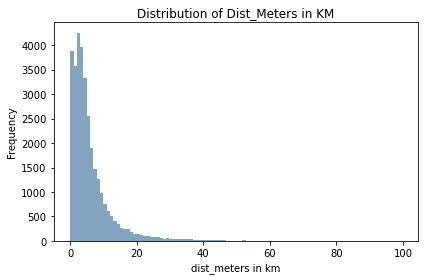

In [18]:
# plotting the distribution of dist_meters
dists = df.dist_meters.loc[df.dist_meters < 100*1000]/1000

plt.figure()
plt.hist(dists, bins= 100, color=(0.2, 0.4, 0.6, 0.6))
plt.title('Distribution of Dist_Meters in KM')
plt.xlabel('dist_meters in km')
plt.ylabel('Frequency')
plt.gcf().patch.set_alpha(0.0)
plt.gca().patch.set_alpha(0.0)
plt.tight_layout()
plt.show()

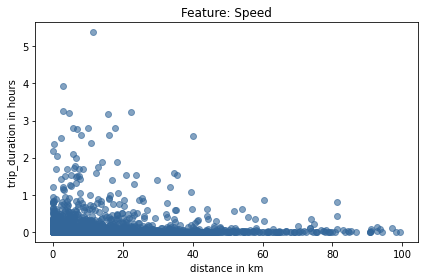

In [19]:
# duration and dist can be combined to speed

speed = df[['dist_meters', 'trip_duration']]
speed = speed.loc[df.dist_meters < 100*1000]/1000
speed = speed.loc[speed.trip_duration > 0]
speed = speed.loc[speed.trip_duration < 8*60*60]
speed['speed'] = (speed.dist_meters/1000)/(speed.trip_duration/3600)

plt.figure()
plt.scatter(x=speed.dist_meters, y=speed.trip_duration/3600, color=(0.2, 0.4, 0.6, 0.6))
plt.title('Feature: Speed')
plt.xlabel('distance in km')
plt.ylabel('trip_duration in hours')
plt.gcf().patch.set_alpha(0.0)
plt.gca().patch.set_alpha(0.0)
plt.tight_layout()
plt.show()

In [20]:
print('Maximum Speed: ', speed.speed.max())

Maximum Speed:  9191.400000000001


**Note**: The new feature speed seems promising, also unrealistic speeds can help again to clean the data. It seems legit to concider speeds beneath 10 km/h and above 120 km/h as unrealistic. 

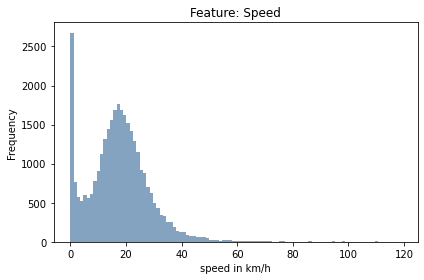

In [21]:
# plotting speed distribution under 120 km/ h 

realistic_speed = speed.speed.loc[speed.speed < 120]

plt.figure()
realistic_speed.plot.hist(bins = 100, color=(0.2, 0.4, 0.6, 0.6))
plt.title('Feature: Speed')
plt.xlabel('speed in km/h')
plt.ylabel('Frequency')
plt.gcf().patch.set_alpha(0.0)
plt.gca().patch.set_alpha(0.0)
plt.tight_layout()
plt.show()

**Note:** Speed is mostly between 10 and 40 km/h which seems reasonable. However there are many entries with speed = 0, which could be cleaned later. 

#### Prediction Feature: Waiting Time

In [22]:
# unrealistic values in wait_sec?
print('wait_sec minimum:', df.wait_sec.min())
print('wait_sec maximum: ', df.wait_sec.max())
print('wait_sec in years: ', df.wait_sec.max()/60/60/24/365)
print('wait_sec bigger than 8h?: ', df.wait_sec.loc[df.wait_sec > 8*60*60].size)

wait_sec minimum: 0
wait_sec maximum:  95163057054
wait_sec in years:  3017.600743721461
wait_sec bigger than 8h?:  437


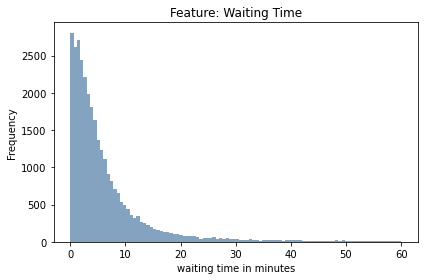

In [23]:
# plotting the prediction feature wait_sec

waiting_time = df['wait_sec'].loc[df['wait_sec'] < 60*60*1]/60

plt.figure()
waiting_time.plot.hist(bins = 100, color=(0.2, 0.4, 0.6, 0.6))
plt.title('Feature: Waiting Time')
plt.xlabel('waiting time in minutes')
plt.ylabel('Frequency')
plt.gcf().patch.set_alpha(0.0)
plt.gca().patch.set_alpha(0.0)
plt.tight_layout()
plt.show()

**Note:** The waiting time is mostly beneath 20 minutes. 

#### Uninformative features:

In [24]:
#store_and_fwd_flag
print('Number of unique items in store_and_fwd_flag: ', df.store_and_fwd_flag.unique())

Number of unique items in store_and_fwd_flag:  ['N']


**Note:** Features without any information can be removed. This feature contains just one item and carries no other information. Maybe if bigger datasets contain different tags here, this should be concicered again.

## Data Cleaning

**Note:** All information gathered in the data exploration that suggest the removal or the subtraction of outliers. Here I will choose to remove data that is unrealistic or is set by my definition as out of range. 

In [25]:
# Cleaning function that apllies all cleaning steps before feature enginering

def clean_data(df): 

    # only keeping the vendor 'Quito'
    df = df.loc[df['vendor_id'] == 'Quito', :]
    df.vendor_id.unique()
    
    # transforming to datetime
    df.loc[:, 'pickup_datetime'] = pd.to_datetime(df.loc[:, 'pickup_datetime'])
    df.loc[:, 'dropoff_datetime'] = pd.to_datetime(df.loc[:, 'dropoff_datetime'])
    
    # deleting uninformative column store_and_flag
    df = df.drop(['store_and_fwd_flag', 'id'], axis=1)

    # removing coordinates out of quito area
    min_long = -0.4
    max_long = -0.05
    min_lat = -78.6
    max_lat = -78.4
    mask_quito = (df.loc[:, 'pickup_latitude'] >= min_long) & (df.loc[:, 'pickup_latitude'] <= max_long)
    mask_quito = mask_quito & (df.loc[:, 'pickup_longitude'] >= min_lat) & (df.loc[:, 'pickup_longitude'] <= max_lat) 
    mask_quito = mask_quito & (df.loc[:, 'dropoff_latitude'] >= min_long) & (df.loc[:, 'dropoff_latitude'] <= max_long)
    mask_quito = mask_quito & (df.loc[:, 'dropoff_longitude'] >= min_lat) & (df.loc[:, 'dropoff_longitude'] <= max_lat) 
    df = df.loc[mask_quito, :]

    # cleaning trip duration for plausible times from 5min to 8h
    df = df.loc[df['trip_duration'] > 5*60, :]
    df = df.loc[df['trip_duration'] < 8*60*60, :]

    # cleaning dist_meters for plausible distances under 100km (Quitos longest distance is approx 60km)
    df = df.loc[df['dist_meters'] > 0, :]
    df = df.loc[df['dist_meters'] < 100*1000, :]
    
    # cleaning wait_sec longer than 8h:
    df = df.loc[df['wait_sec'] < 8*60*60, :]
    
    return df

## Feature Engineering

In [26]:
# function needed for calculating the distance between coordinates
# modified version found on:
# https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points

def haversine_(lat1, lng1, lat2, lng2):
    """haversine distance: 
    great-circle distance between two points on a sphere given their longitudes and latitudes."""
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    
    lat = lat2 - lat1
    lng = lng2 - lng1
    
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    
    return(h)

In [27]:
def feature_engineering(df):


    # create features from datetime:  
    # hour/weekday/ weekend/ season

    df['pickup_time'] = df['pickup_datetime'].dt.hour
    df['dropoff_time'] = df['dropoff_datetime'].dt.hour
    
    # creating feature rush_hour
    df['rush_hour'] = df.pickup_time.isin([6,7,8,9]).astype(int)

    # only pickup month should be enough, since a ride is always shorter than a day
    df['pickup_month'] = df['pickup_datetime'].dt.month
    
    #creating feature busy_season:
    df['busy_season'] = df.pickup_month.isin([1, 12, 6, 7]).astype(int)
    

    # weekday for pickup
    df['weekday'] = df['pickup_datetime'].dt.dayofweek

    # create feature weekend, weekend = 0, weekday = 1
    df['weekend'] = (df['weekday'] < 5).astype(int)

    # create feature speed

    df['speed_km_h'] = (df['dist_meters']/1000) / (df['trip_duration']/60/60)

    # cleaning speed for plausible values

    df = df.loc[df.speed_km_h < 120]
    df = df.loc[df.speed_km_h > 5]

    # creating features based on distance to the city center
    # and direction of the trip -> uptown or downtown


    # coordinates of Quito City center, estimated on latlong.net

    quito_center = (-0.175, -78.5)

    # creating feature 'distance to center' for pickup and dropoff
    df["pickup_distance_to_center"] = \
        df[['pickup_latitude','pickup_longitude']].apply(
        lambda x: haversine_(x[0],x[1],quito_center[0],quito_center[1]),axis = 1)

    df["dropoff_distance_to_center"] = \
        df[['dropoff_latitude','dropoff_longitude']].apply(
        lambda x: haversine_(x[0],x[1],quito_center[0],quito_center[1]),
                                                     axis = 1)

    # creating feature for going downtown or uptown
    # is the distance to center getting bigger or smaler?
    df["to_center"] = \
        (df["pickup_distance_to_center"] > \
        df["dropoff_distance_to_center"]).astype(int)  
    
    return df


#### Applying Data Cleaning and Feature Engineering on Data Set

**Note:** I decided to do the data cleaning on the whole data set and then apply the train-test split, since I do only remove unrealistic values that are completely out of range. Therefore I decided to clean the whole data set, even if this implies that I have cleaned the test set.

In [28]:
# reading in the data frame again in case of changes

df = pd.read_csv("uio_clean.csv")

before = len(df)
print('data set size before cleaning: ', before)

# apply data cleaning function
df = clean_data(df)
after = len(df)
print('data set size after cleaning: ', after)
print('Number of removed data points:', before - after)

# apply feature engineering function

before_eng = len(df)
df = feature_engineering(df)
after_eng = len(df)
print('Removed Data Points in engineering: ', before_eng - after_eng)

data set size before cleaning:  32366
data set size after cleaning:  25363
Number of removed data points: 7003


/usr/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


Removed Data Points in engineering:  1789


In [29]:
df.head()

,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,wait_sec,...,dropoff_time,rush_hour,pickup_month,busy_season,weekday,weekend,speed_km_h,pickup_distance_to_center,dropoff_distance_to_center,to_center
0,Quito,2016-09-17 09:32:06,2016-09-17 10:05:51,-78.503922,-0.232824,-78.549447,-0.361363,2025,24228,346,...,10,1,9,0,5,0,43.072000,6.444522,21.439570,0
3,Quito,2016-09-18 05:57:47,2016-09-18 06:30:00,-78.558076,-0.278241,-78.430220,-0.201934,1933,25146,302,...,6,0,9,0,6,0,46.831661,13.171534,8.317123,1
4,Quito,2016-09-18 07:58:42,2016-09-18 08:14:29,-78.521818,-0.208480,-78.504558,-0.222462,948,4625,314,...,8,1,9,0,6,0,17.563291,4.443580,5.301858,0
5,Quito,2016-08-27 04:19:02,2016-08-27 04:44:12,-78.509202,-0.194839,-78.518764,-0.228794,1510,5820,630,...,4,0,8,0,5,0,13.875497,2.431700,6.335084,0
6,Quito,2016-09-18 10:08:57,2016-09-18 10:31:18,-78.481542,-0.154317,-78.518420,-0.191547,1341,7593,510,...,10,0,9,0,6,0,20.383893,3.082500,2.753324,1


#### Preparing Data Set for ANN -> One-Hot-Encoding and Scaling

In [30]:
# one-hot encoding
#df = pd.get_dummies(df, columns=['pickup_month','pickup_time'])


from sklearn.preprocessing import MinMaxScaler
# scaling 
scaler = MinMaxScaler()

df[['speed_km_h', 
         'dist_meters', 
         'trip_duration', 
         'pickup_distance_to_center', 
         ]] = \
        scaler.fit_transform(df[['speed_km_h', 
                                     'dist_meters', 
                                     'trip_duration', 
                                     'pickup_distance_to_center',
                                     ]])


In [31]:
df.columns

Index(['vendor_id', 'pickup_datetime', 'dropoff_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'trip_duration', 'dist_meters', 'wait_sec', 'pickup_time',
       'dropoff_time', 'rush_hour', 'pickup_month', 'busy_season', 'weekday',
       'weekend', 'speed_km_h', 'pickup_distance_to_center',
       'dropoff_distance_to_center', 'to_center'],
      dtype='object')

## Modelling

In [32]:
# Imports: 
import sklearn 

#train-test-split
from sklearn.model_selection import train_test_split

# Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Regression
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVC

# Validation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

# Metrics
from sklearn.metrics import mean_absolute_error

#### Performing Train-Validatation-Test Split:

In [33]:
# splitting data set in target and features

target = df.loc[:,'wait_sec']
features = df.drop('wait_sec', axis = 1)

# creating train and test set: 
X_train, X_test, \
y_train, y_test = \
train_test_split(features, target, \
                 random_state=4, test_size = 0.1)

# creating validation set from training set
X_train, X_val, \
y_train, y_val = \
train_test_split(X_train, y_train, \
                 random_state=4, test_size = 0.1)

#### Selecting Features

In [34]:
# feature selection: 
feature_cols         = ['speed_km_h',
                        'weekend',
                        'rush_hour',
                        'busy_season',
                        #'pickup_month',
                        #'dropoff_time',
                        #'pickup_time', 
                        'dist_meters',
                        'trip_duration',
                        'pickup_distance_to_center',
                        #'dropoff_distance_to_center',
                        'to_center',  
                       ]

remove_features = ['vendor_id', 'pickup_datetime', 'dropoff_datetime', 'pickup_longitude', 'pickup_latitude',
                  'dropoff_longitude', 'dropoff_latitude', 'dropoff_time', 'weekday']

X_train = X_train.loc[:, feature_cols]
X_val = X_val.loc[:, feature_cols]
X_test = X_test.loc[:, feature_cols]

#X_train = X_train.drop(remove_features, axis=1)
#X_val = X_val.drop(remove_features, axis=1)
#X_test = X_test.drop(remove_features, axis=1)

In [35]:
X_train.head()

,speed_km_h,weekend,rush_hour,busy_season,dist_meters,trip_duration,pickup_distance_to_center,to_center
29372,0.248871,1,1,1,0.061066,0.015965,0.234288,1
28093,0.105114,1,0,1,0.027760,0.014804,0.295986,1
24790,0.114034,1,1,0,0.015543,0.004209,0.172696,0
30059,0.046391,0,0,1,0.009526,0.007329,0.271007,1
15631,0.144344,1,0,1,0.014100,0.000907,0.131444,0


#### Baseline Model Linear Regression: 

In [36]:
#simple baseline model

linreg = LinearRegression().fit(X_train, y_train)

print('Test Set MAE for linear Regresison: ', 
      sklearn.metrics.mean_absolute_error(linreg.predict(X_test), y_test))


Test Set MAE for linear Regresison:  185.47632045330852


#### Running ANN 

**Note:** I have tried many different architectures and parameter from simple to more complex and want to show one of the good models I found.

In [37]:
# importing tensorflow modules

import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Activation, Lambda, Dense, Dropout, BatchNormalization
from tensorflow.python.keras.optimizers import SGD

In [38]:
# Model Architecture

ann_model = Sequential()

# input layer
ann_model.add(Input(X_train.shape[1]))

ann_model.add(Dense(32))
ann_model.add(BatchNormalization())
ann_model.add(Activation('relu'))
ann_model.add(Dropout(0.2))

# hidden layer
ann_model.add(Dense(16))
ann_model.add(BatchNormalization())
ann_model.add(Activation('relu'))
ann_model.add(Dropout(0.2))

ann_model.add(Dense(8))
ann_model.add(BatchNormalization())
ann_model.add(Activation('relu'))
ann_model.add(Dropout(0.2))

# Output layer
ann_model.add(Dense(1,
               activation='linear'))

ann_model.summary()


# Parameters
learning_rate = 0.01
momentum = 0.9
epochs = 16
batch_size = 256

# saving best model
checkpoint_filepath = 'checkpoint/'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_mae',
    mode='min',
    save_best_only=True)


#optimizer
sgd = tf.keras.optimizers.SGD(learning_rate, momentum)

ann_model.compile(loss='mae', 
                  optimizer=sgd, 
                  metrics=['mse','mae'])

ann_model_history = ann_model.fit(X_train, y_train, 
                                  validation_data=(X_val, y_val),
                        epochs=epochs, 
                        batch_size=batch_size,  
                        verbose=1,
                        callbacks=[model_checkpoint_callback])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                288       
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
activation (Activation)      (None, 32)                0         
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
activation_1 (Activation)    (None, 16)                0

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


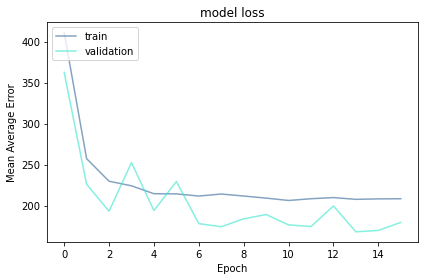

In [39]:
# plotting the trianing and validation loss curves

print(ann_model_history.history.keys())

plt.figure()
plt.plot(ann_model_history.history['mae'], color=(0.2, 0.4, 0.6, 0.6))
plt.plot(ann_model_history.history['val_mae'], color=(0.2, 0.9, 0.8, 0.6))
plt.title('model loss')
plt.ylabel('Mean Average Error')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.gcf().patch.set_alpha(0.0)
plt.gca().patch.set_alpha(0.0)
plt.tight_layout()
plt.show()

#### Model Selection and Evaluation

**Note:** I have chosen to take the best parameter set from the validation set and use it as my best model. 

In [40]:
# load best model from validation set

ann_model.load_weights(checkpoint_filepath)

print('Test Set MAE on best model: ', 
      mean_absolute_error(ann_model.predict(X_test), y_test))

Test Set MAE on best model:  179.3683742623495
